<a href="https://colab.research.google.com/github/SilaWahome/Machine-Learning-and-Python/blob/main/Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving green-maize-02.jpg to green-maize-02 (7).jpg


Plant Name,Probability
Zea mays,47.03%

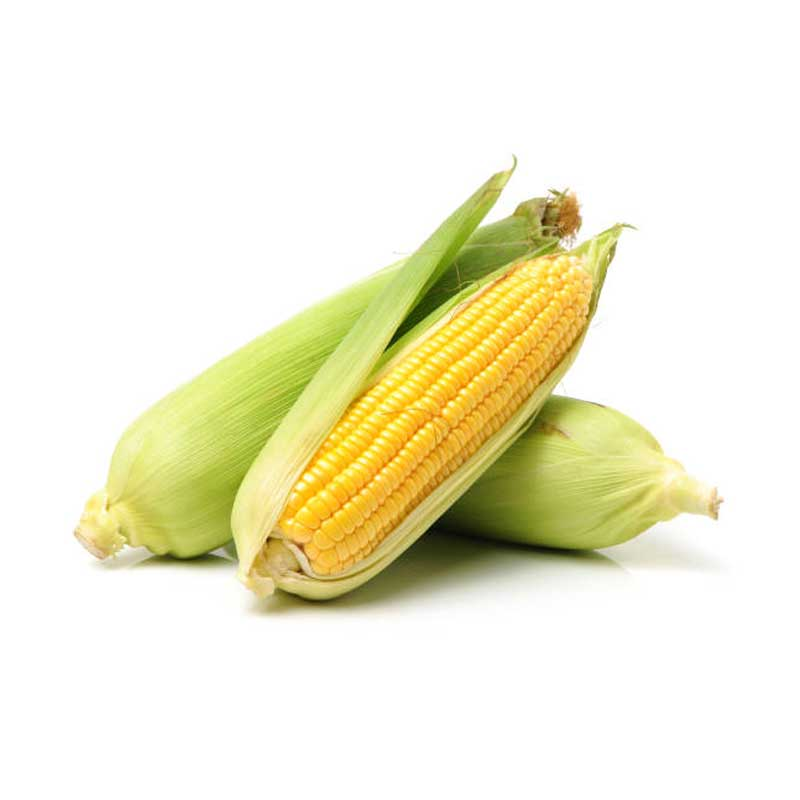

Error with Crop Health API: 201
{"access_token": "rQSZ5ZBMIKNGUBD", "model_version": "crop_health:1.2.1", "custom_id": null, "input": {"latitude": -1.286389, "longitude": 36.817223, "similar_images": true, "images": ["https://crop.kindwise.com/media/images/de3524128d6648a79213ef56ad840bab.jpg"], "datetime": "2025-05-07T17:24:39.321066+00:00"}, "result": {"is_plant": {"probability": 0.057383318, "threshold": 0.5, "binary": false}, "disease": {"suggestions": [{"id": "c35556c0c67c0591", "name": "healthy", "probability": 0.9315, "similar_images": [{"id": "6c4a52a65aa9242688c52aa18f2c06b2a6933b54", "url": "https://crop-health.ams3.cdn.digitaloceanspaces.com/similar_images/1/6c4/a52a65aa9242688c52aa18f2c06b2a6933b54.jpg", "license_name": "CC0", "license_url": "https://creativecommons.org/publicdomain/zero/1.0/", "citation": "Amanda Boyle", "similarity": 0.61, "url_small": "https://crop-health.ams3.cdn.digitaloceanspaces.com/similar_images/1/6c4/a52a65aa9242688c52aa18f2c06b2a6933b54.small.jpg

In [38]:
import requests
from datetime import datetime, timezone
from google.colab import files
from IPython.display import display, HTML
import base64

# Configuration
PLANT_API_KEY = "g8vaPbyZOl4ceAtjD4Xyhjbrd0fUvrxF46NyNzXN7xlKJJqJwz"
CROP_API_KEY = "9WSLAG88OgrVc5JalxQoEgeWnENSYLFR8ZGA5A79u2SMKSJwQx"
PLANT_API_URL = "https://api.plant.id/v2/identify"
CROP_API_URL = "https://crop.kindwise.com/api/v1/identification"

# Metadata
latitude = -1.286389
longitude = 36.817223
timestamp = int(datetime.now(tz=timezone.utc).timestamp())

# Upload image interactively
uploaded = files.upload()
IMAGE_PATH = next(iter(uploaded))

# Read and encode the image
try:
    with open(IMAGE_PATH, "rb") as image_file:
        image_bytes = image_file.read()
        encoded_image = base64.b64encode(image_bytes).decode('utf-8')
except FileNotFoundError:
    print(f"Error: Image file not found at {IMAGE_PATH}")
    exit(1)

# Plant Identification
plant_headers = {"Api-Key": PLANT_API_KEY}
plant_data = {
    "organs": ["leaf"],
    "latitude": latitude,
    "longitude": longitude,
    "datetime": timestamp
}
plant_files = {"images": image_bytes}

plant_response = requests.post(PLANT_API_URL, headers=plant_headers, files=plant_files, data=plant_data)

if plant_response.status_code == 200:
    plant_result = plant_response.json()
    plant_name = plant_result['suggestions'][0]['plant_name']
    probability = plant_result['suggestions'][0]['probability']

    # Display Plant Identification Result
    html_output = f"""
        <h3>Uploaded Image</h3>
        <div style="border: 1px solid #ccc; padding: 10px; display: inline-block;">
            <img src="data:image/jpeg;base64,{encoded_image}" width="200">
        </div>
        <h3>Plant Identification Result</h3>
        <table>
            <tr><th>Plant Name</th><th>Probability</th></tr>
            <tr><td>{plant_name}</td><td>{probability:.2%}</td></tr>
        </table>
    """
    display(HTML(html_output))

    # Crop Health Assessment
    crop_headers = {"Api-Key": CROP_API_KEY}
    crop_payload = {
        "images": [encoded_image],
        "latitude": latitude,
        "longitude": longitude,
        "similar_images": True
    }

    crop_response = requests.post(CROP_API_URL, headers=crop_headers, json=crop_payload)

    if crop_response.status_code == 200:
        crop_result = crop_response.json()
        diseases = crop_result['result']['disease']['suggestions']
        crops = crop_result['result']['crop']['suggestions']

        # Display Crop Health Assessment
        disease_rows = ""
        for disease in diseases:
            name = disease['name']
            prob = disease['probability']
            disease_rows += f"<tr><td>{name}</td><td>{prob:.2%}</td></tr>"

        crop_rows = ""
        for crop in crops:
            name = crop['name']
            prob = crop['probability']
            crop_rows += f"<tr><td>{name}</td><td>{prob:.2%}</td></tr>"

        html_output_health = f"""
            <h3>Crop Health Assessment</h3>
            <h4>Disease/Pest Suggestions:</h4>
            <table>
                <tr><th>Disease Name</th><th>Probability</th></tr>
                {disease_rows}
            </table>
            <h4>Crop Suggestions:</h4>
            <table>
                <tr><th>Crop Name</th><th>Probability</th></tr>
                {crop_rows}
            </table>
        """
        display(HTML(html_output_health))
    else:
        print("Error with Crop Health API:", crop_response.status_code)
        print(crop_response.text)
else:
    print("Error with Plant Identification API:", plant_response.status_code)
    print(plant_response.text)
